In [35]:
import numpy as np

from qiskit import IBMQ, Aer, QuantumCircuit, assemble, transpile
from qiskit.providers.ibmq import least_busy
from qiskit.visualization import plot_histogram

CIRCUITO ESPECÍFICO

In [36]:
n = 3
const_oracle = QuantumCircuit(n+1)

In [37]:
output = np.random.randint(2)
if output == 1:
    const_oracle.x(n)

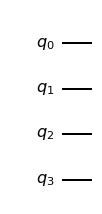

In [38]:
const_oracle.draw()

In [39]:
balanced_oracle = QuantumCircuit(n+1)

In [40]:
b_str = "101"
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

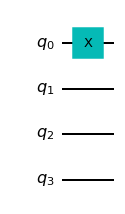

In [41]:
balanced_oracle.draw()

In [8]:
balanced_oracle.barrier()

In [9]:
for qubit in range(n):
    balanced_oracle.cx(qubit, n)

balanced_oracle.barrier()

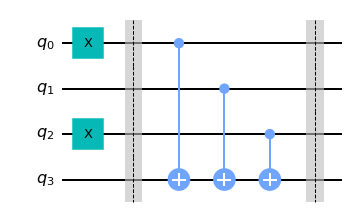

In [10]:
balanced_oracle.draw()

In [11]:
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

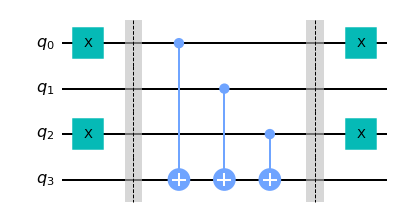

In [12]:
balanced_oracle.draw()

In [13]:
dj_circuit = QuantumCircuit(n+1, n)

In [14]:
for qubit in range(n):
    dj_circuit.h(qubit)
    
dj_circuit.x(n)
dj_circuit.h(n)

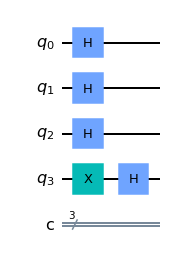

In [15]:
dj_circuit.draw()

In [16]:
dj_circuit += balanced_oracle

/tmp/ipykernel_346/254046861.py:1: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  dj_circuit += balanced_oracle


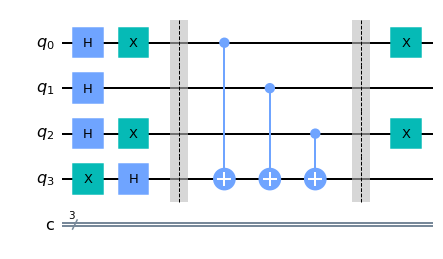

In [17]:
dj_circuit.draw()

In [18]:
for qubit in range(n):
    dj_circuit.h(qubit)
    
dj_circuit.barrier()

In [19]:
for i in range(n):
    dj_circuit.measure(i, i)

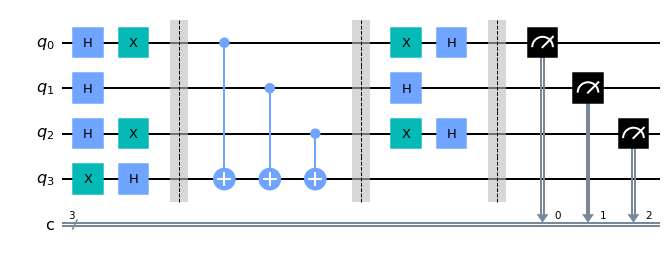

In [20]:
dj_circuit.draw()

In [21]:
aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(dj_circuit, aer_sim)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

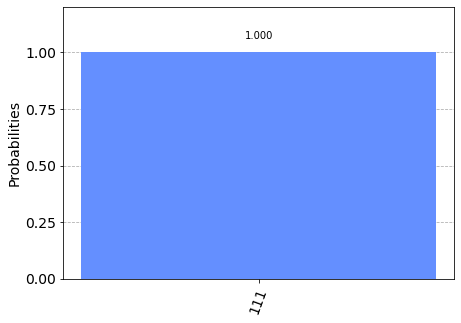

In [22]:
plot_histogram(answer)

CIRCUITO GENERALIZADO

Teste SIMULADOR

In [23]:
def dj_oracle(case, n):
    oracle_qc = QuantumCircuit(n+1)
    
    if case == 'balanced':
        b = np.random.randint(1, 2**n)
        b_str = format(b, '0'+str(n)+'b')
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
    
    if case == 'constant':
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = 'Oracle'
    
    return oracle_gate

In [24]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    
    dj_circuit.x(n)
    dj_circuit.h(n)
    
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    dj_circuit.append(oracle, range(n+1))
    
    for qubit in range(n):
        dj_circuit.h(qubit)
        
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

In [25]:
n = 4
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)

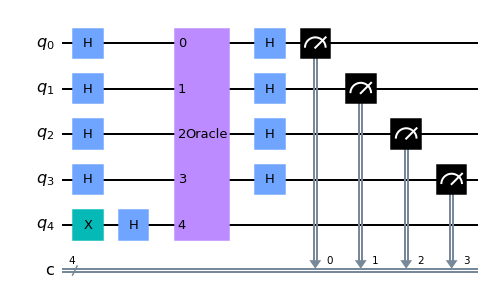

In [26]:
dj_circuit.draw()

In [27]:
trans_dj_circuit = transpile(dj_circuit, aer_sim)
qobj = assemble(trans_dj_circuit)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

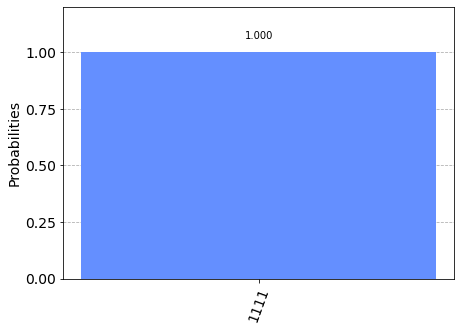

In [28]:
plot_histogram(answer)

Teste COMPUTADOR QUÂNTICO

In [29]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_quito


In [30]:
from qiskit.tools.monitor import job_monitor

transpiled_dj_circuit = transpile(dj_circuit, backend, optimization_level=3)
job = backend.run(transpiled_dj_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


In [31]:
results = job.result()
answer = results.get_counts()

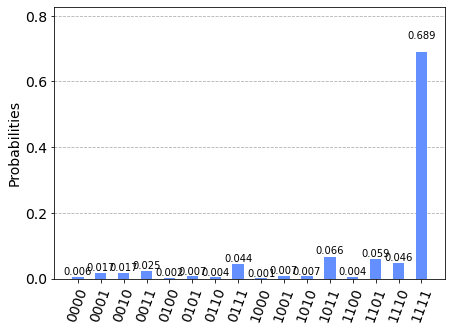

In [32]:
plot_histogram(answer)